In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import periodogram, welch
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [20,10]

In [3]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('11');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('11');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [1]:
def visualize_time_series(time_series,
                          name,
                          nlags=52,
                          rolling=12,
                          n_format=',.0f',
                          nperseq=100,
                          period=52):
    fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(10, 30))
    ax.ravel()
    mean = time_series.rolling(rolling).mean()
    std = time_series.rolling(rolling).std()
    realization_plot = sns.lineplot(data=time_series,
                                    ax=ax[0],
                                    ci=None,
                                    label='Realization')
    sns.lineplot(data=mean,
                 color='red',
                 ax=ax[0],
                 ci=None,
                 label=f'{rolling} Period MA')
    realization_plot.lines[1].set_linestyle('--')
    sns.lineplot(data=std,
                 color='green',
                 ax=ax[0],
                 ci=None,
                 label=f'{rolling} Period Volatility')
    realization_plot.lines[2].set_linestyle('--')

    realization_plot.set_title(f'Realization: {name}')
    realization_plot.set_yticklabels(
        [f'{y:,.0f}' for y in realization_plot.get_yticks()])

    acf = sm.tsa.acf(time_series.dropna(), nlags=nlags, fft=False)
    pacf = sm.tsa.pacf_ols(time_series.dropna(), nlags=nlags)
    acf = sns.barplot(data=pd.DataFrame({
        'lag': range(1, len(acf)),
        'acf': acf[1:]
    }),
                      x='lag',
                      y='acf',
                      ax=ax[1],
                      color='blue',
                      alpha=0.2)
    pacf = sns.barplot(data=pd.DataFrame({
        'lag': range(1, len(pacf)),
        'pacf': pacf[1:]
    }),
                       x='lag',
                       y='pacf',
                       ax=ax[2],
                       color='blue',
                       alpha=0.2)
    period_gram = welch(time_series, scaling='spectrum', nperseg=nperseq)
    max_freq = period_gram[0][period_gram[1].argmax()]
    period_gram = sns.lineplot(data=pd.DataFrame({
        'frequency':
        period_gram[0],
        'power':
        period_gram[1] / max(period_gram[1])
    }),
                               x='frequency',
                               y='power',
                               ax=ax[3])
    acf.axhline(y=-1.96 / np.sqrt(len(time_series)),
                linestyle='--',
                color='gray')
    acf.axhline(y=1.96 / np.sqrt(len(time_series)),
                linestyle='--',
                color='gray')
    pacf.axhline(y=-1.96 / np.sqrt(len(time_series)),
                 linestyle='--',
                 color='gray')
    pacf.axhline(y=1.96 / np.sqrt(len(time_series)),
                 linestyle='--',
                 color='gray')

    acf.set_title(f'ACF: {name}')
    pacf.set_title(f'PACF: {name}')
    period_gram.set_title(
        f'Spectral Density: Peak {round(max_freq, 3)} Hz - Window: {nperseq}')
    pacf.set_xticklabels(pacf.get_xticklabels(), rotation=-45)
    acf.set_xticklabels(acf.get_xticklabels(), rotation=-45)
    period_gram.set_yscale('log')
    fig.subplots_adjust(hspace=0.3)
    fig.tight_layout()
    time_series.index = pd.DatetimeIndex(time_series.index, freq='infer')
    decomposition = sm.tsa.seasonal_decompose(time_series.dropna(),
                                              model='additive',
                                              period=period)
    trend = sns.lineplot(data=decomposition.trend,
                         color='black',
                         ax=ax[4],
                         ci=None,
                         label=f'{name} - Trend')
    seasonal = sns.lineplot(data=decomposition.seasonal,
                            color='black',
                            ax=ax[5],
                            ci=None,
                            label=f'{name} - Seasonal')
    residuals = sns.lineplot(data=decomposition.resid,
                             color='black',
                             ax=ax[6],
                             ci=None,
                             label=f'{name} - Residual')
    trend.set_title(f'{name} - Trend')
    seasonal.set_title(f'{name} - Seasonality for Periodicity {period}')
    residuals.set_title(f'{name} - Residuals')

    return decomposition


def fit_time_series(time_series,
                    max_ar=6,
                    max_ma=4,
                    seasonality=52,
                    trend='ct'):
    model_select = sm.tsa.arma_order_select_ic(y=time_series,
                                               ic=['aic', 'bic'],
                                               trend='nc',
                                               max_ar=max_ar,
                                               max_ma=max_ma)
    aic_select = model_select['aic_min_order']
    bic_select = model_select['bic_min_order']
    print(f'AIC selects: AR({aic_select[0]}) MA({aic_select[1]})')
    print(f'BIC selects: AR({bic_select[0]}) MA({bic_select[1]})')
    model_aic = sm.tsa.arima.ARIMA(endog=time_series,
                                   order=(aic_select[0], 0, aic_select[1]),
                                   trend=trend)
    aic_fit = model_aic.fit()
    model_bic = sm.tsa.arima.ARIMA(endog=time_series,
                                   order=(bic_select[0], 0, bic_select[1]),
                                   trend=trend)
    bic_fit = model_bic.fit()
    model_seasonal = sm.tsa.arima.ARIMA(endog=time_series,
                                        seasonal_order=(bic_select[0], 0,
                                                        bic_select[1],
                                                        seasonality),
                                        trend=trend)
    seasonal_fit = model_seasonal.fit()
    return aic_fit, bic_fit, seasonal_fit

## Introduction

In our case study, we will be using ARIMA to model the seasonal flu. We will be extracting historical flu data from the World Health Organization database that focuses on positive influenza cases that occured in the United States dating back from the 2000's to present date. The data from the WHO is provided by FluNet, which is a global web-based tool for influenza virological surveillance. The data that is recorded into FluNet tracks the movement of viruses globally and are publically available and updated weekly. We will be using Python to estimate ARIMA model parameters (p,d,q) using autocorrelation functions and rule-based decision making. The ARIMA model can be used to better understand the data or to forecast future values when the data shows evidence of non-stationarity.

The autoregressive integrated moving average model (ARIMA) is group of three parameters: autoregressive (p), integrated (d), moving average (q). The differences satisfy a stationary ARMA(p,q) model where d is the non-negative integer. All of these parameters are based on a linear function of the preceding values and noise which can impose a constraint of linearity on the function that generates the time series data. The ARIMA model can be used to better understand the data or to forecast future values when the data shows evidence of non-stationarity.

The SARIMA model is variation on the ARIMA model which accounts for seasonality. SARIMA models are incredibly helpful when used to predict non-stationary data. 

## Objective

- Extract historical flu data (positive cases over time) – you can choose to model flu patterns at the national or regional/state-level

- Build an ARIMA model; determine the appropriate values for (p,d,q)

- How well does your model perform on validation data? (Note: you’ll need to create a training and validation set to measure forecast accuracy)

- Provide analysis to support your determinations

### Definition of an ARMA process

- An ARMA process is **stationary** if all of its AR roots lie outside the unit circle.

- An ARMA process is **invertible** if all of its MA roots lie outside the unit circle.

$$y_{t}=\phi_{1}y_{t-1}+\ldots+\phi_{p}y_{t-p}+\theta_{1}\epsilon_{t-1}
           +\ldots+\theta_{q}\epsilon_{t-q}+\epsilon_{t}$$
    
$$ Where\ the\ \phi\ are\ the\ AR\ Frequencies\ and\ the\ \theta\ are\ the\ MA\ Frequencies\ $$

### Load Data

In [5]:
data = pd.read_csv('FluNetInteractiveReport.csv')
data_nas = data.describe()

***Parse Dates to Datetime***

In [6]:
data['SDATE'] = pd.to_datetime(data['SDATE'])
data['EDATE'] = pd.to_datetime(data['EDATE'])

***Set Index to EDATE***

In [7]:
data.set_index(['EDATE'], inplace=True)

Removing Bermuda due to lack of observations

In [8]:
data = data[data.Country != 'Bermuda']

In [9]:
data = data.groupby(data.index)[['ALL_INF']].sum()

In [10]:
data.describe()

,ALL_INF
count,1330.000000
mean,1737.901504
std,4243.777898
min,0.000000
25%,8.000000
50%,166.500000
75%,1152.250000
max,30771.000000


### Train Test Split

- Use data from **2016-2018** for all of **North America** as a train set to build our models. Testing will occur on 2019 and 2020 to determine which model is our best fit

- Dropping observations from Bermuda (very few observations) and only keeping data from 2016 onwards per the client warnings on data integrity for previous periods.

- Modeling will take place on the **INF_ALL** variable, which represents the total number of positive tests, independent of the influenza strain (Type A or Type B) 

In [11]:
data = data[data.index.year > 2015]
train_data = data[
    (data.index.year < 2019)]
                 # data[data.index.year.isin([2016, 2017, 2018])]
test_data = data[data.index.year.isin([2019, 2020])]

count      157.000000
mean      4797.738854
std       7118.912362
min         86.000000
25%        284.000000
50%       1265.000000
75%       6778.000000
max      30771.000000
Name: ALL_INF, dtype: float64


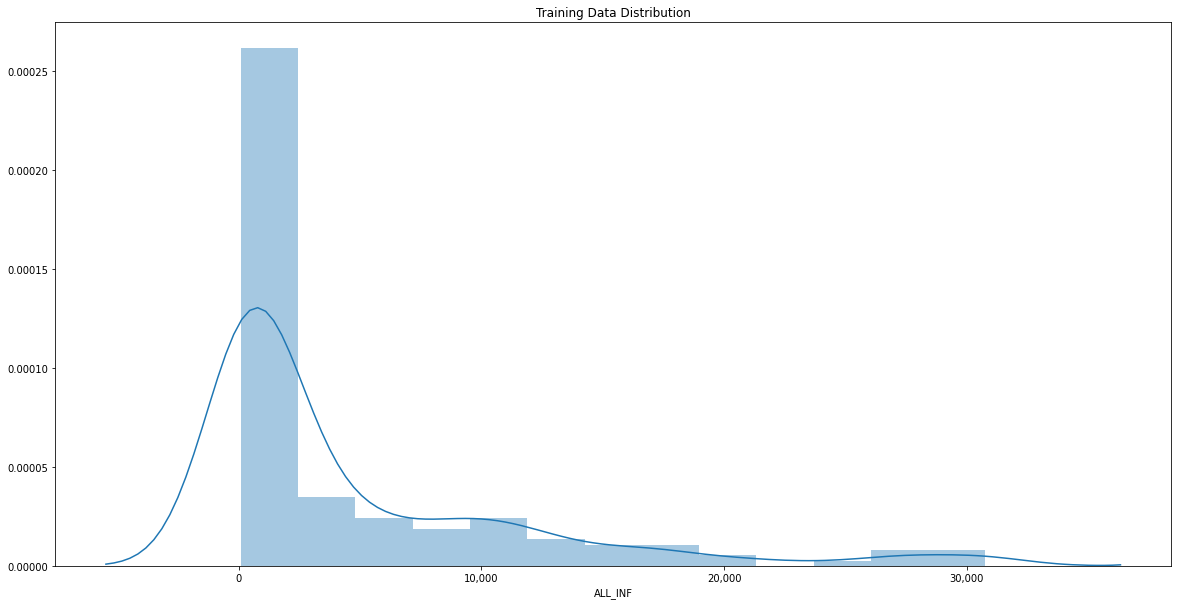

In [12]:
p = sns.distplot(train_data['ALL_INF'])
p.set_xticklabels([f'{x:,.0f}' for x in p.get_xticks()])
p.set_title('Training Data Distribution')
print(train_data['ALL_INF'].describe())


count       78.000000
mean      7472.551282
std       9182.395635
min          0.000000
25%        358.250000
50%       1585.000000
75%      15416.000000
max      30419.000000
Name: ALL_INF, dtype: float64


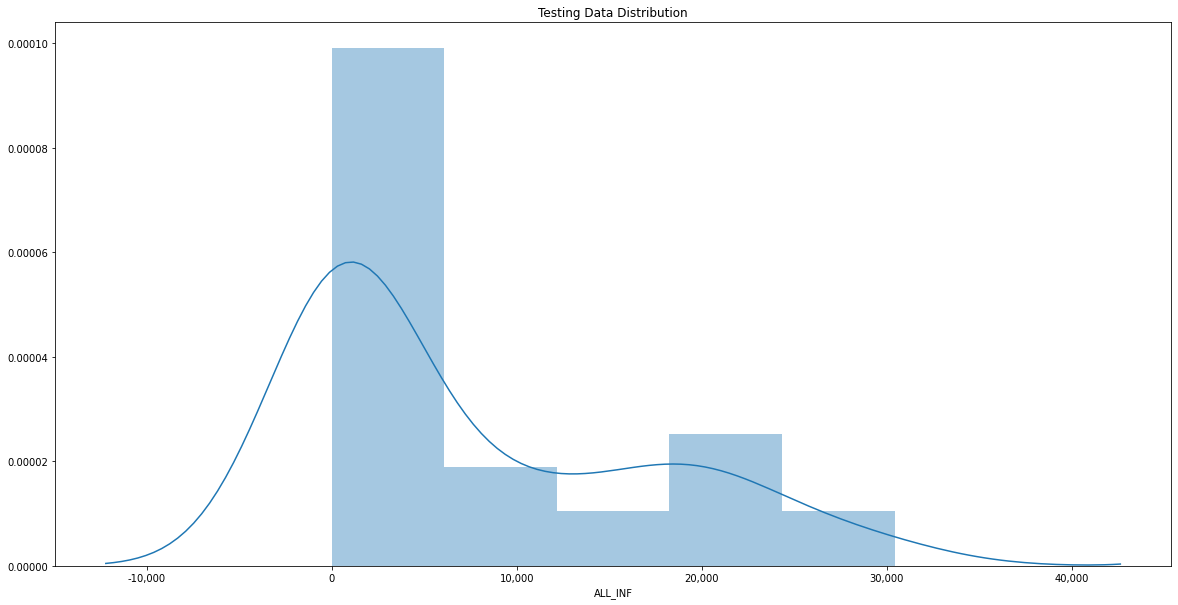

In [13]:
p = sns.distplot(test_data['ALL_INF'])
p.set_xticklabels([f'{x:,.0f}' for x in p.get_xticks()])
p.set_title('Testing Data Distribution')
print(test_data['ALL_INF'].describe())

There are 157 observations in our train set and 78 in the test set. Normally, a less balanced split would be appropriate, but because the data is temporal in nature, it is critical that careful attention is paid to where the train/test cutoff date is chosen. Cutting the data in the middle of a flu season could lead to erroneous predictions.


#### Condition 1: Is the mean time-dependent?

Yes, the mean is dependent on time. By looking at the realizations below, we notice that every year the number of positive cases increases and decreases depending on month. In our plots below, we notice that the positive cases start increasing around November and reaches its peak around January before droping back down into July. This makes sense because typically flu season begins during the cold part of the year during winter season. This would indicate that, over and over and over again, that the mean of the process that was driving this seems to be dependent on time. In our case, condition 1 is not met.

#### Condition 2: Is there evidence of heteroskesdacity?

Condition 2 is not met, since there is evidence of heteroskesdacity. Based on the rolling variance in the realization graphs below, we can see that the variances are not constant and that the variance is dependent on time.


#### Condition 3: Is there a constant correlation structure?

Considering the ACF/PACF of the partitioned data set below, we can see that the correlation structure for the first half of our data is nearly identical to that of our second half (partitioning the dataset into two equal halves). Condition 3 is met. 

Often, statistical tests such as the **Dickey-Fuller** test are used to determine stationarity, but that particular test is often error prone (non-stationary time series often pass the test). If possible, visual inspection of ACF and PACF plot is preferrable to relying on a statistical test that has no context with which to frame the data as is often required in time series analysis.

Since conditions 1 and 2 **are not** met, modeling as a non-stationary time series seems like the proper approach.

Text(0.5, 1.0, 'PACF: Second Half')

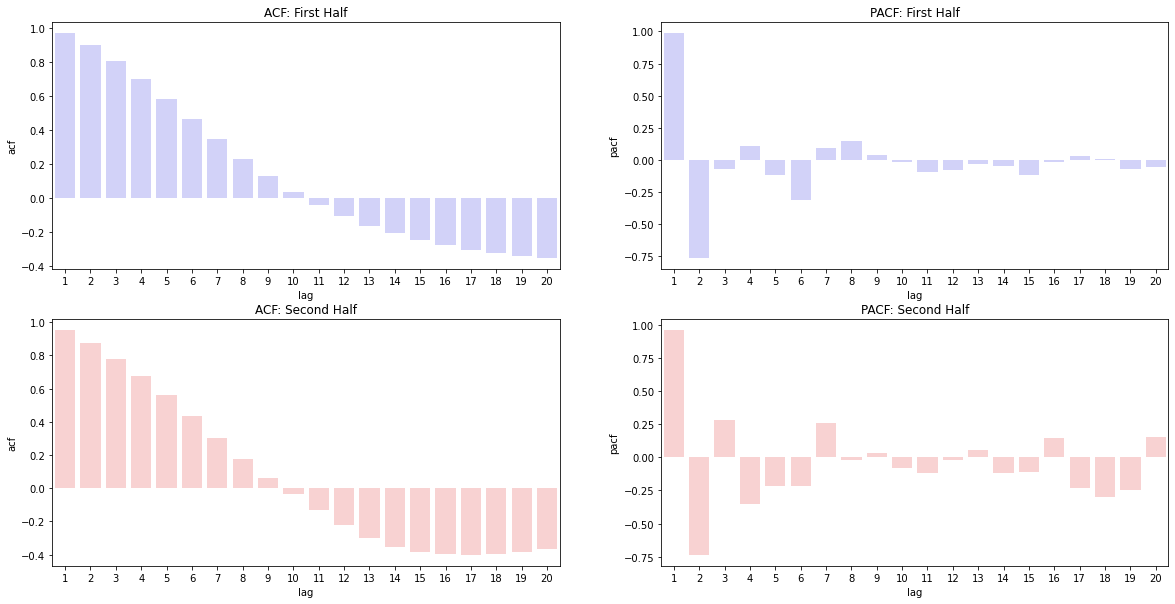

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2)
ax.ravel()
acf_1 = sm.tsa.acf(data[:167], nlags=20, fft=False)
pacf_1 = sm.tsa.pacf_ols(data[:167], nlags=20)
acf_1 = sns.barplot(data=pd.DataFrame({'lag':range(1, len(acf_1)),
                          'acf':acf_1[1:]}), x='lag', y='acf', ax=ax[0, 0], color='blue', alpha=0.2)
pacf_1 = sns.barplot(data=pd.DataFrame({'lag':range(1, len(pacf_1)),
                          'pacf':pacf_1[1:]}), x='lag', y='pacf', ax=ax[0, 1], color='blue', alpha=0.2)

acf_2 = sm.tsa.acf(data[167:], nlags=20, fft=False)
pacf_2 = sm.tsa.pacf_ols(data[167:], nlags=20)
acf_2 = sns.barplot(data=pd.DataFrame({'lag':range(1, len(acf_2)),
                          'acf':acf_2[1:]}), x='lag', y='acf', ax=ax[1, 0], color='red', alpha=0.2)
pacf_2 = sns.barplot(data=pd.DataFrame({'lag':range(1, len(pacf_2)),
                          'pacf':pacf_2[1:]}), x='lag', y='pacf', ax=ax[1, 1], color='red', alpha=0.2)
acf_1.set_title('ACF: First Half')
acf_2.set_title('ACF: Second Half')
pacf_1.set_title('PACF: First Half')
pacf_2.set_title('PACF: Second Half')

Text(0.5, 1.0, 'All Infections: 2016-2020')

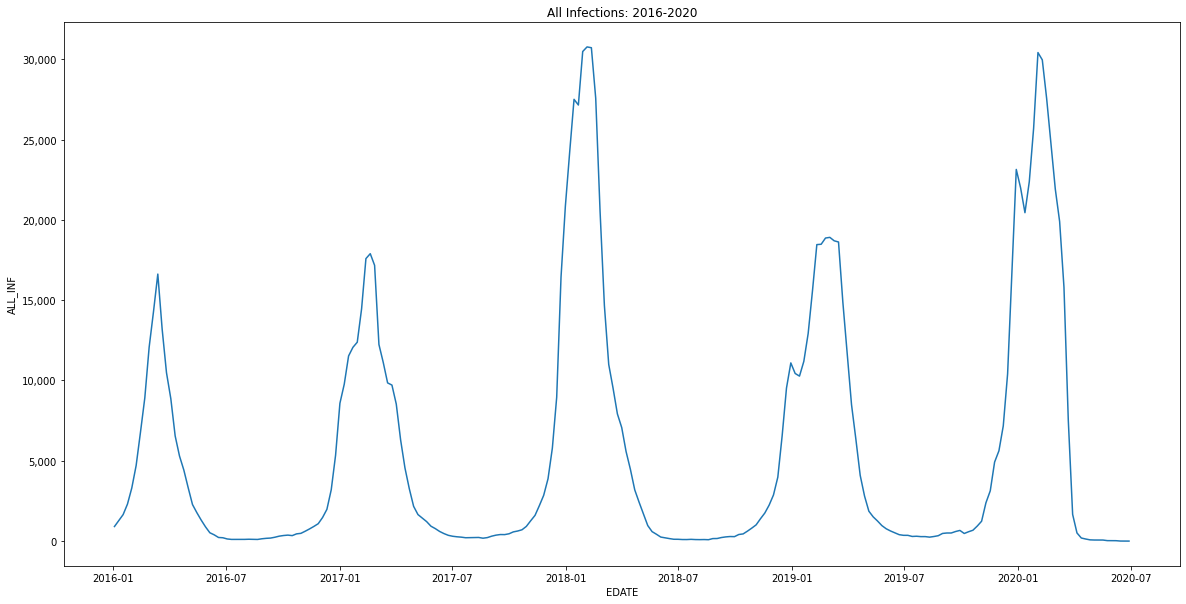

In [15]:
p = sns.lineplot(data=data, x=data.index, y='ALL_INF')
p.set_yticklabels([f'{y:,.0f}' for y in p.get_yticks()])
p.set_title('All Infections: 2016-2020')

In [16]:
time_series_train = train_data
time_series_test = test_data

## [Statsmodels Time Series Analysis]('https://www.statsmodels.org/stable/tsa.html')

- Explore the autocorrelation (**ACF**) and partial autocorrelation (**PACF**) structures of our time series. 

- Explore the ***Power Spectral Density*** of our time series to search for known system frequencies.

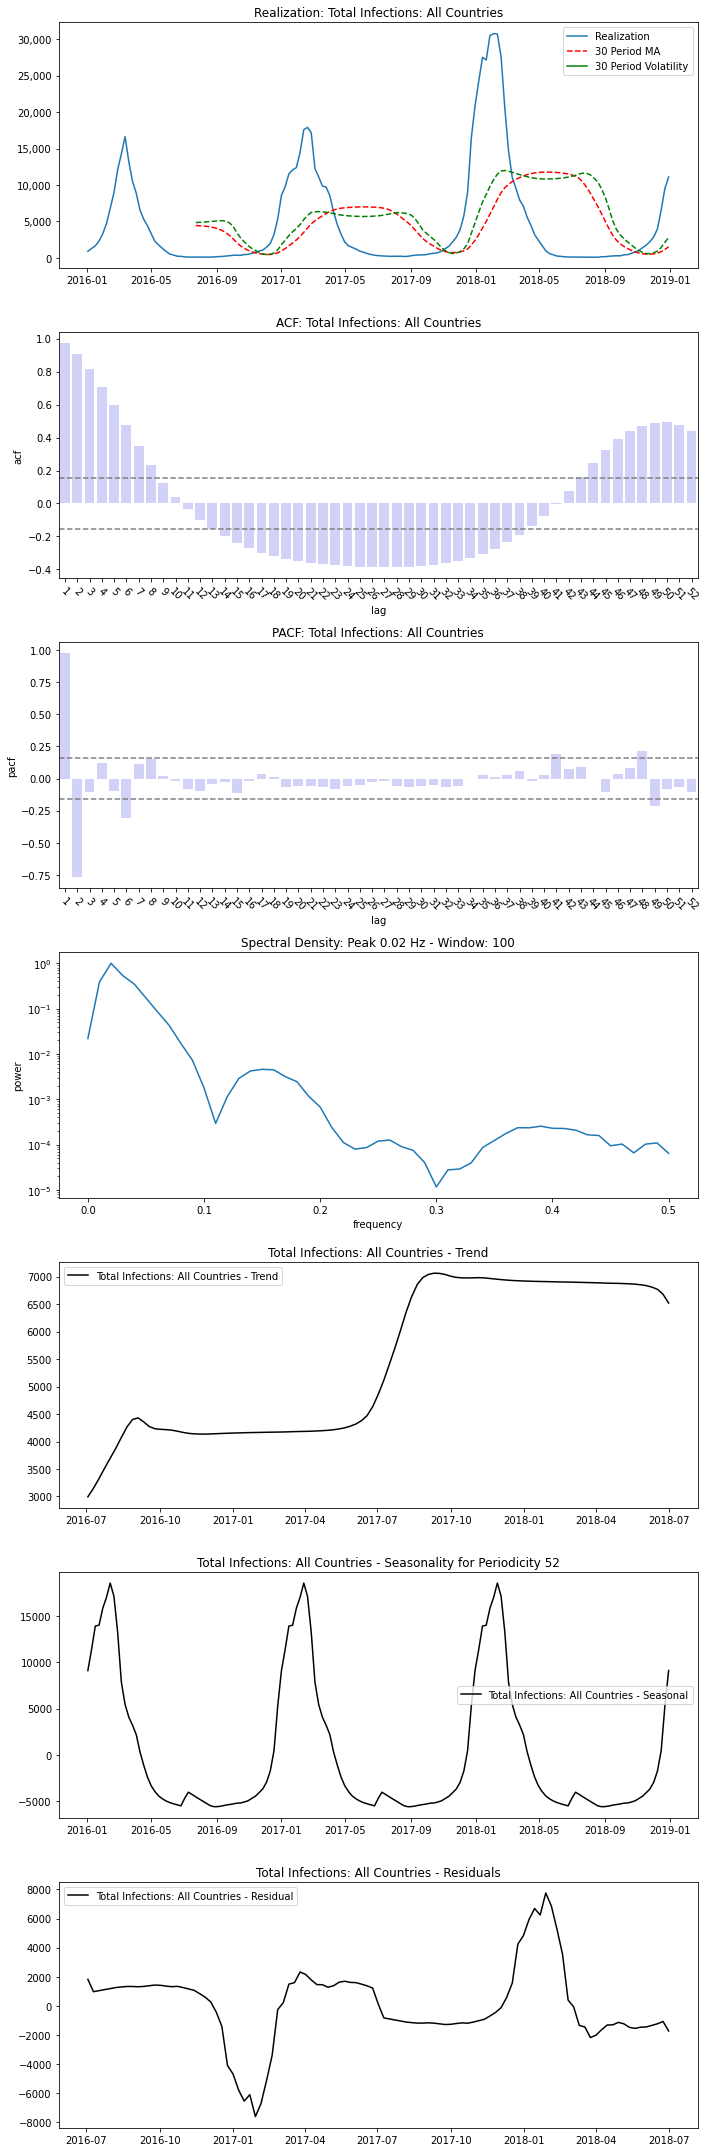

In [17]:
decomp = visualize_time_series(time_series_train['ALL_INF'], name='Total Infections: All Countries', rolling=30)

***ACF*** 

The ACF for our realization shows evidence of strong, positive autocorrelations across the first 8 lags and then switches to slightly less strong, negative correlations from lag 12 - lag 39. Finally, exhibiting strong, positive autocorrelations again at lags 44-52. This is entirely expected given that the data is sampled on a weekly basis and should be strongly correlated year over year. The negative autocorrelations show that there is a strong tendency towards reverting to a flat period of infection rates in between seasons (i.e May through November)

***PACF***

From the PACF, evidence of a lull period is clear. Between lags 8 and 44, correlations drop below our signficance level indicating that there is a 36 week period (roughly 9 months) where there is little to no activity (the negtive correlations indicating that values are expected to be lower than they were in the past). This matches to what is shown in the realization - spikes in infection rates, followed by extended periods of inactivity.

***Spectral Density***

From the spectral density chart, this time series most likely has an AR component with a value of p greater than 1 since there is no way to observer multiple system frequencies between 0 and 0.5 for p < 2. AR(1) processes have system frequencies of 0 or 0.5. The strong peak at approximately 0.019 Hz shows that a seasonal component with a periodicity of 52 is highly likely.  

***Trend***

Strong evidence of an increasing trend towards the end of 2017 leading into the flu season of 2018. 

***Seasonality***

The seasonal decomposition predicts roughly 15k case peak per season. It underestimates the spike in 2018 by approximately 8k cases and overstates the 2017 season by roughly the same amount. The seasonal model produced by the decomposition package will simply predict the value from 52 periods prior, indefinitely. 

***Residuals***

The residuals of our seasonal decomposition appear to be roughly normal but potentially bi-modal. The seasonal decomposition fails to accurately model **when** spikes will occur (peaks are often just a bit early or just a bit late), but it does do an excellent job of capturing the trends in the time series.

             resid
count   105.000000
mean     76.843997
std    2674.985957
min   -7600.526196
25%   -1231.579080
50%     128.186945
75%    1385.267073
max    7754.214189


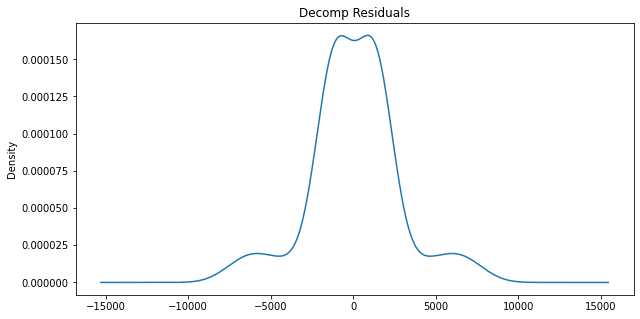

In [18]:
plt.figure(figsize=(10,5))
decomp.resid.plot(kind='kde', title='Decomp Residuals')
print(pd.DataFrame(decomp.resid).describe())

### Model Search

- Using the **arma_order_select_ic** function in statsmodels.api, we will perform a large parameter search for optimal values of (p,q). One model will be selected based on **AIC**, another based on **BIC**. Typically, BIC is the favored metric so as to avoid overfitting. 

- An **SARIMA** model with an assumption of 52 period seasonality will be created using the optimal values for p, q selected by BIC as our P,Q values for the seasonal model.

In [19]:
aic_fit, bic_fit, seasonal_fit = fit_time_series(time_series_train)

AIC selects: AR(6) MA(2)
BIC selects: AR(2) MA(2)


In [20]:
aic_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ALL_INF   No. Observations:                  157
Model:                 ARIMA(6, 0, 2)   Log Likelihood               -1303.086
Date:                Wed, 01 Jul 2020   AIC                           2628.171
Time:                        09:39:05   BIC                           2661.790
Sample:                    01-03-2016   HQIC                          2641.825
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4513.1592   3800.131      1.188      0.235   -2934.961     1.2e+04
x1             9.5598     49.704      0.192      0.847     -87.858     106.978
ar.L1          1.5545      0.273      5.686      0.000       1.019       2.090
ar.L2         -0.6105      0.487     -1.254      0.210      -1.565       0.344
ar.L3         -0.0401      0.589     -0.068      0.946      -1.195       1.115
ar.L4         -0.0512      0.291     -0.176      0.860      -0.621       0.519
ar.L5          0.3514      0.158      2.218      0.027       0.041       0.662
ar.L6         -0.2822      0.092     -3.076      0.002      -0.462      -0.102
ma.L1          0.0885      0.307      0.288      0.773      -0.513       0.690
ma.L2          0.3149      0.362      0.870      0.384      -0.395       1.024
sigma2      9.669e+05   7.96e+04     12.146      0.000    8.11e+05    1.12e+06
===================================================================================
Ljung-Box (Q):                       12.45   Jarque-Bera (JB):               499.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.62
Prob(H) (two-sided):                  0.68   Kurtosis:                        11.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***Best AIC Fit Summary***

Statistically signficant parameter estimates at AR lags 1, 5, and 6. All other parameter estimates contain zero in the interval and are not significant. 

In [21]:
bic_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ALL_INF   No. Observations:                  157
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1309.648
Date:                Wed, 01 Jul 2020   AIC                           2633.297
Time:                        09:39:05   BIC                           2654.691
Sample:                    01-03-2016   HQIC                          2641.986
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4512.9019   5537.411      0.815      0.415   -6340.224    1.54e+04
x1             9.5344     61.160      0.156      0.876    -110.337     129.406
ar.L1          1.5063      0.059     25.352      0.000       1.390       1.623
ar.L2         -0.5655      0.057     -9.860      0.000      -0.678      -0.453
ma.L1          0.1752      0.085      2.054      0.040       0.008       0.342
ma.L2          0.4376      0.050      8.838      0.000       0.341       0.535
sigma2      9.976e+05   6.78e+04     14.724      0.000    8.65e+05    1.13e+06
===================================================================================
Ljung-Box (Q):                       23.56   Jarque-Bera (JB):               450.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.78
Prob(H) (two-sided):                  0.22   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***Best BIC Fit Summary***

Statistically signficant parameter estimates at AR/MA at lags 1 and 2. Since the BIC typically produces a more parsimonious model it is usually preferred over AIC.

In [22]:
seasonal_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:                     ALL_INF   No. Observations:                  157
Model:             ARIMA(2, 0, [1, 2], 52)   Log Likelihood               -1589.839
Date:                     Wed, 01 Jul 2020   AIC                           3193.678
Time:                             09:39:05   BIC                           3215.072
Sample:                         01-03-2016   HQIC                          3202.367
                              - 12-30-2018                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4513.1295   3121.507      1.446      0.148   -1604.911    1.06e+04
x1            10.8303     31.066      0.349      0.727     -50.057      71.718
ar.S.L52       0.9512    863.954      0.001      0.999   -1692.367    1694.270
ar.S.L104     -0.2476    420.820     -0.001      1.000    -825.040     824.545
ma.S.L52      -0.2523    864.195     -0.000      1.000   -1694.044    1693.539
ma.S.L104     -0.0647    184.916     -0.000      1.000    -362.494     362.364
sigma2      4.968e+07      0.116   4.27e+08      0.000    4.97e+07    4.97e+07
===================================================================================
Ljung-Box (Q):                      859.53   Jarque-Bera (JB):               195.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                             2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.86e+24. Standard errors may be unstable.
"""

Based solely on the interpretation of these parameters, this model looks awful. None of them are statistically significant. Note that we need to examine how the statsmodels.api interprets the P, D, Q, s parameters as it appears to be slightly different from the **tswge** package in R.

### Model Evaluation

Of all 3 models, the AIC of the seasonal model was worst. But because we have established that our data is non-stationary, we should weight the predictive power of our model over the statistical likelihood associated with AIC/BIC.

Each of our 3 candidate models will be evaluated on an out of sample predictions on 2019 and 2020. Our criterion for model efficacy will be **RSS** (residual sum of squared error)

***NB on predict and forecast functions in statsmodel.api***

https://stackoverflow.com/questions/45596492/statsmodels-arima-different-results-using-predict-and-forecast

### Predictions


In [23]:
predict_aic = aic_fit.forecast(steps=len(time_series_test))
predict_bic = bic_fit.forecast(steps=len(time_series_test))
predict_seasonal = seasonal_fit.forecast(steps=len(time_series_test))
rss_aic=pd.DataFrame(predict_aic)
rss_aic =rss_aic.join(time_series_test)
rss_aic =(rss_aic.iloc[:,0]-rss_aic.iloc[:,1])**2
rss_aic = np.sqrt(rss_aic.sum())
rss_bic = pd.DataFrame(predict_bic)
rss_bic =rss_bic.join(time_series_test)
rss_bic =(rss_bic.iloc[:,0]-rss_bic.iloc[:,1])**2
rss_bic = np.sqrt(rss_bic.sum())
rss_seasonal = pd.DataFrame(predict_seasonal)
rss_seasonal =rss_seasonal.join(time_series_test)
rss_seasonal =(rss_seasonal.iloc[:,0]-rss_seasonal.iloc[:,1])**2
rss_seasonal = np.sqrt(rss_seasonal.sum())


print(f'AIC Best RSS:{rss_aic}')
print(f'BIC Best RSS:{rss_bic}')
print(f'Seasonal RSS:{rss_seasonal}')

AIC Best RSS:78578.96066677256
BIC Best RSS:80050.58131426717
Seasonal RSS:59077.26628580058


By far, the seasonal model performed best in our out of sample testing. Let's examine the predictions made by each.

### AIC Best Model  AR(6) MA(2)

From the below we can see that having the higher-order AR terms allows the capture of some of the cyclic behaviour seen in the realization. The addition of the MA terms serves to dampen the oscillations rather quickly and reverts to the mean.

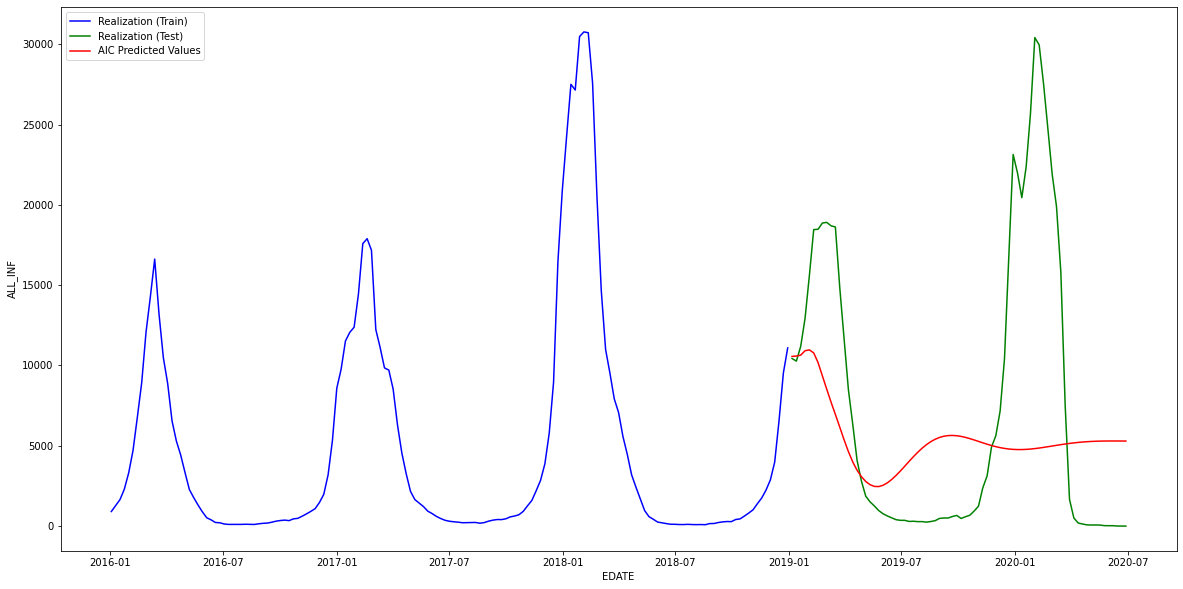

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
p = sns.lineplot(data=time_series_train, x=time_series_train.index, y='ALL_INF', color='blue', label='Realization (Train)', ax=ax)
p = sns.lineplot(data=time_series_test, x=time_series_test.index, y='ALL_INF', color='green', label='Realization (Test)', ax=ax)
p = sns.lineplot(data=predict_aic, color='red', label='AIC Predicted Values', ax=ax)

### BIC Best Model  AR(2) MA(2)

From the below we can see that without the higher-order AR terms leads to the MA terms being dominant. Mean reversion is swift and leads to a model that predicts terribly relative to its more sophisticated competition.

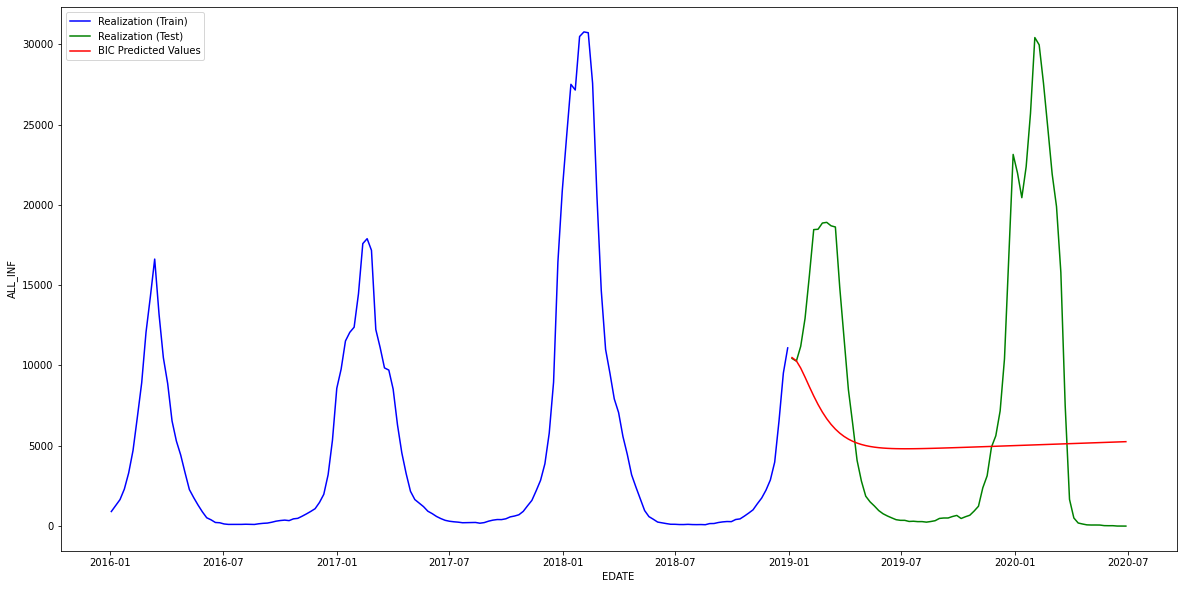

In [25]:
plt.figure(figsize=(20,10))
sns.lineplot(data=time_series_train, x=time_series_train.index, y='ALL_INF', color='blue', label='Realization (Train)')
sns.lineplot(data=time_series_test, x=time_series_test.index, y='ALL_INF', color='green', label='Realization (Test)')
sns.lineplot(data=predict_bic, color='red', label='BIC Predicted Values')

### Seasonal Model: SARIMA (2, 0, 2, 52)

Combining the behaviour of the ARIMA model with an assumption of 52 week seasonality proved to be the best model by a wide margin. Further tuning of the P, Q parameters may have lead to an even better model.

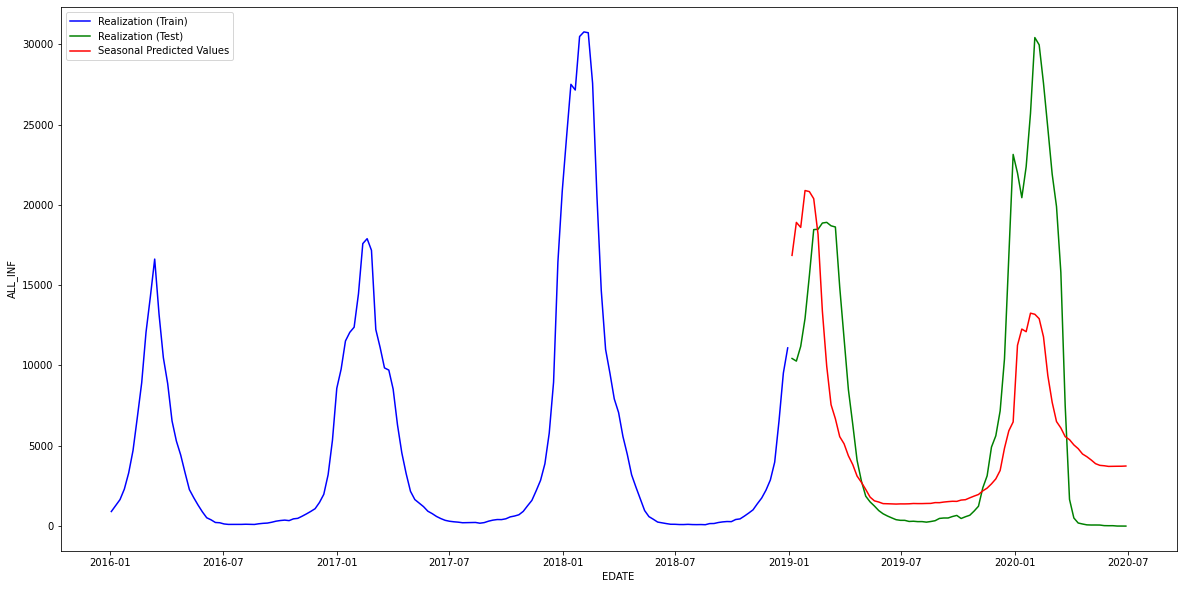

In [26]:
plt.figure(figsize=(20,10))
sns.lineplot(data=time_series_train, x=time_series_train.index, y='ALL_INF', color='blue', label='Realization (Train)')
sns.lineplot(data=time_series_test, x=time_series_test.index, y='ALL_INF', color='green', label='Realization (Test)')
sns.lineplot(data=predict_seasonal, color='red', label='Seasonal Predicted Values')

## Conclusions:

Modeling non-stationary time series with purely stationary models is nearly impossible. Purely auto-regressive models fail miserably as do purely moving average models. Seasonal models should be employed wherever possible to address issues assocciated with non-stationarity (mean depending on time, non-constant variance and serial correlations).

Further analysis should be carried out to assess the rates of infection with respect to the number of tests administered. This would allow for a more apples/apples comparison across time periods where the total number of positive cases was significantly higher in certain seasons versus others. This is an issue many are having with the current COVID19 out break: administering more tests is in the public's interest, but it will also likely lead to more cases being detected, which is not always politically popular (particularly for a sitting president in a pandemic).

No analysis was carried out on specific strains of the flu, though the code here could easily be used for such a purpose. There were slight differences in the realizations for strain A vs strain B, hence modeling them separately may be useful. 

More analysis could also be carried out at the country or state level to see if there are areas where outbreaks are particularly acute vs areas where outbreaks are rare. Additionally, building models that only look at periods where infection rates are high could be very fruitful in buidling out an ensemble model that combines different assumptions of seasonality. This is left as an excercise for the curious mind.